In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
import powerlaw
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plot_filepath = "C:\\Users\\luist\\OneDrive\\Escritorio\\Luis Torrejón\\UZH\\FALL22\\Network Science\\project\\"
save_plots = True
#global_dataset="mathoverflow"
global_dataset="stackoverflow"

In [14]:
def load_network_from_txt(filepath):
    edgelist = np.loadtxt(filepath)
    network = nx.Graph()
    network.add_edges_from(edgelist)
    return network

def load_network_from_year(year):
    return load_network_from_txt(f"data/project/{global_dataset}_{year}.txt")
    
years = ["2010", "2011", "2012", "2013", "2014", "2015"]
    
#stackoverflow_network_data = []
#for year in years:
#    stackoverflow_network_data.append(load_network_from_txt(f"data/project/stackoverflow_{year}.txt"))
#mathoverflow_network_data = []
#for year in years:
#    mathoverflow_network_data.append(load_network_from_txt(f"data/project/mathoverflow_{year}.txt"))

In [15]:
def get_largest_cluster_size(network):
    return [len(c) for c in sorted(nx.connected_components(network), key=len, reverse=True)][0]

def get_sorted_adj_matrix(network):
    adjm = nx.adjacency_matrix(network)
    adjm_dense = adjm.todense()
    ones_per_row = []
    for row in adjm_dense:
        ones_per_row.append(np.count_nonzero(row == 1))
    ones, indexes = zip(*sorted(zip(ones_per_row, list(range(np.shape(adjm_dense)[0])))))
    indexes = indexes[::-1]
    adjm_dense = adjm_dense[indexes, :]
    return adjm_dense

def get_eigenvector_centrality(network):
    return nx.eigenvector_centrality(network)

def get_degree_centrality(network):
    return nx.degree_centrality(network)

def get_network_degrees(network):
    network_degrees = network.degree()
    return np.array([network_degrees[i] for i in network.nodes()])

def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def exponential(k, lamb):
    return (1./lamb) * np.exp(-k/lamb)

def plot_degree_distributions_and_evolutions(years):
    gamma_values = []
    sigma_values = []
    avr_degree_values = []
    for year in years:
        network = load_network_from_year(year)
        gamma, sigma, avr_degree = plot_degree_distribution_and_fit(network, year)
        gamma_values.append(gamma)
        sigma_values.append(sigma)
        avr_degree_values.append(avr_degree)
    # plot gamma evolution
    plt.figure(figsize=(10,7))
    plt.title(r'$\alpha$' + " evolution", fontsize=25)
    plt.errorbar(years, 
                 np.array(gamma_values), 
                 yerr=np.array(sigma_values),
                 ecolor="red", 
                 marker="o", 
                 capsize=5)
    plt.xlabel("Year", fontsize=20)
    plt.ylabel(r'$\alpha$', fontsize=20)
    plt.tick_params(axis='both', labelsize=16)
    if save_plots:
        plt.savefig(plot_filepath + f"{global_dataset}_alpha_evolution.png")
    plt.show()
    
    # plot average degree evolution
    plt.figure(figsize=(10,7))
    plt.title("Average degree evolution", fontsize=25)
    plt.plot(years, 
             np.array(avr_degree_values),
             marker="o")
    plt.xlabel("Year", fontsize=20)
    plt.ylabel(r'$<k>$', fontsize=20)
    plt.tick_params(axis='both', labelsize=16)
    if save_plots:
        plt.savefig(plot_filepath + f"{global_dataset}_degree_evolution.png")
    plt.show()
    
    

def plot_degree_distribution_and_fit(network, year, poissonFlag=False, exponentialFlag=False):
    degree_values = get_network_degrees(network)
    nodes = network.number_of_nodes()
    degrees = list(set(degree_values))
    avr_degree = sum(degree_values)/nodes
    fit = powerlaw.Fit(degree_values, discrete=True)
    gamma = fit.power_law.alpha
    sigma = fit.power_law.sigma

    plt.figure(figsize=(10,7))
    plt.title(f"Year={year}", fontsize=25)
    fit.power_law.plot_pdf(color='red', linestyle='--', 
                           label="Power-law fit: " + str(round(gamma, 3)) + '$\pm$' + str(round(sigma, 3)))
    powerlaw.plot_pdf(degree_values, color='blue', marker='o', label="Empirical distribution")
    if poissonFlag:
        poisson_dist = poisson(np.array(degrees), avr_degree)
        plt.plot(degrees, poisson_dist, color='green', label="Poisson distribution")
        plt.ylim(ymax=1)
        plt.ylim(ymin=1.5e-6)
    if exponentialFlag:
        exponential_dist = exponential(np.array(degrees), avr_degree)
        plt.plot(degrees, exponential_dist, color='orange', label="Exponential distribution")
        plt.ylim(ymax=1)
        plt.ylim(ymin=1.5e-6)
    plt.legend(fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("$k$", fontsize=20)
    plt.ylabel("$P(k)$", fontsize=20)
    plt.tick_params(axis='both', labelsize=16)
    if save_plots:
        if poissonFlag or exponentialFlag:
            plt.savefig(plot_filepath + f"{global_dataset}_degree_distribution_allfits_{year}.png")
        else:
            plt.savefig(plot_filepath + f"{global_dataset}_degree_distribution_powerlaw_{year}.png")
    plt.show()
    return gamma, sigma, avr_degree

def plot_degree_distribution(network, year):
    degrees = get_network_degrees(network)
    bins = np.logspace(np.log10(min(degrees)),np.log10(max(degrees) + 1), 25)
    plt.figure(figsize=(10,7))
    plt.tick_params(axis='both', labelsize=16)
    plt.hist(degrees, bins = bins, density=True)
    plt.title(f"Degree distribution, year={year}", fontsize=20)
    plt.xlabel('Degree', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.yscale('log')
    plt.xscale('log')
    avr_degree = sum(degrees)/len(degrees)
    plt.axvline(x = avr_degree, color = 'r', label = f"average degree = {round(avr_degree, 2)}")
    plt.legend(fontsize=16)
    if save_plots:
        plt.savefig(plot_filepath + f"{global_dataset}_degree_distribution_{year}.png")
    plt.show()
    
def plot_largest_cluster_size_evolution(years):
    network_size = []
    for year in years:
        network = load_network_from_year(year)
        network_size.append(get_largest_cluster_size(network))
    plt.figure(figsize=(10,7))
    plt.tick_params(axis='both', labelsize=16)
    plt.title("Evolution of the largest cluster's size", fontsize=25)
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Size of largerst cluster", fontsize=20)
    plt.plot(years, network_size, marker='o')
    if save_plots:
        plt.savefig(plot_filepath + f"{global_dataset}_size_evolution.png")
    plt.show()
    
def plot_eigenvector_vs_degree_centralities(years):
    for year in years:
        network = load_network_from_year(year)
        eigenvector = get_eigenvector_centrality(network)
        eigenvector_list = [eigenvector[i] for i in network.nodes()]

        degree = get_degree_centrality(network)
        degree_list = [degree[i] for i in network.nodes()]

        plt.figure(figsize=(10,7))
        plt.tick_params(axis='both', labelsize=16)
        plt.title(f"Year={year}", fontsize=25)
        plt.xlabel("Degree centrality", fontsize=20)
        plt.ylabel("Eigenvector centrality", fontsize=20)
        plt.scatter(degree_list, eigenvector_list)
        plt.text(max(degree_list)*0.6, min(eigenvector_list), 
                 "Spearman coefficient = " + str(round(st.spearmanr(degree_list, eigenvector_list)[0], 3)), size=17)
        if save_plots:
            plt.savefig(plot_filepath + f"{global_dataset}_eigenvector_vs_degree_{year}.png")
        plt.show()
        
def get_ranking_centralities(year, rank_number):
    network = load_network_from_year(year)
    eigenvector = get_eigenvector_centrality(network)
    eigenvector_list = [eigenvector[i] for i in network.nodes()]
    eigenvector_rank = sorted(eigenvector_list)[::-1][:rank_number]
    degree = get_degree_centrality(network)
    degree_list = [degree[i] for i in network.nodes()]
    degree_rank = sorted(degree_list)[::-1][:rank_number]
    return (eigenvector_rank, degree_rank)

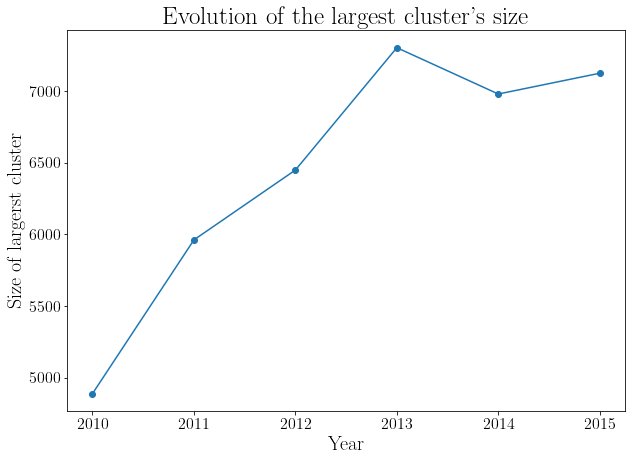

In [14]:
plot_largest_cluster_size_evolution(years)

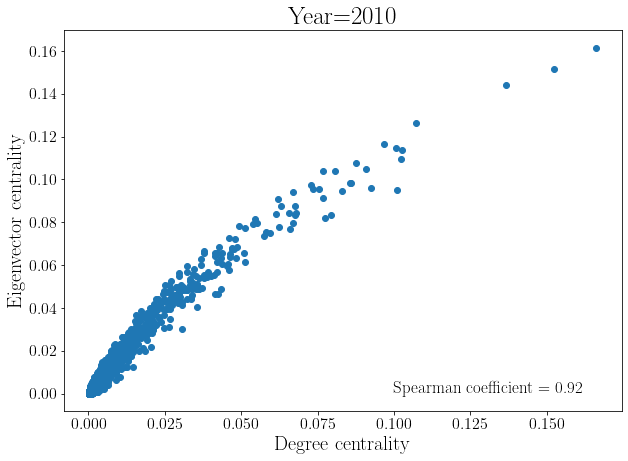

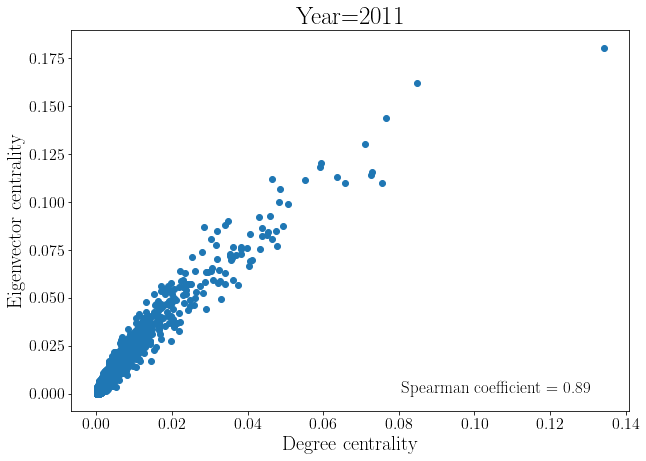

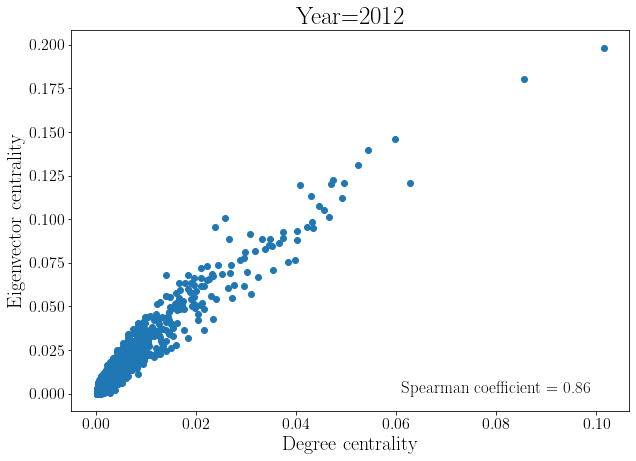

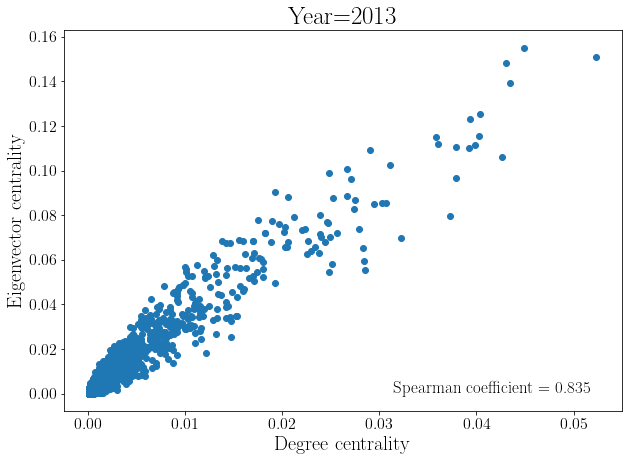

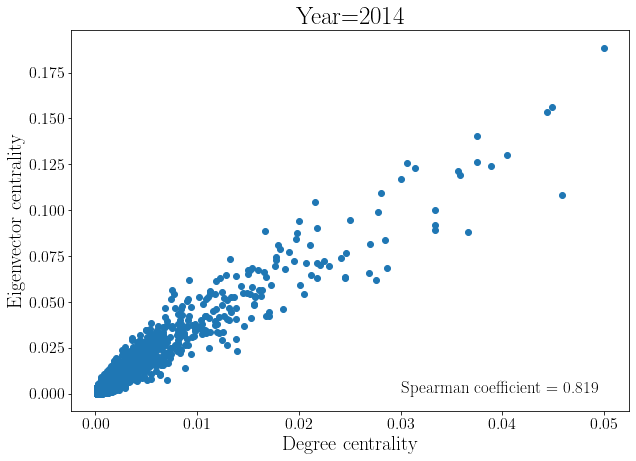

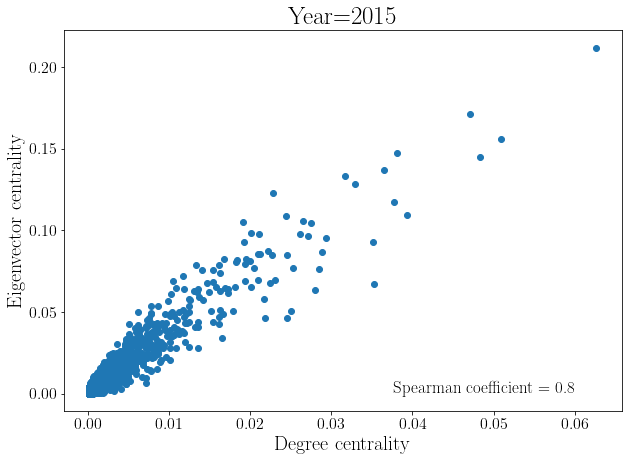

In [18]:
plot_eigenvector_vs_degree_centralities(years)

Calculating best minimal value for power law fit


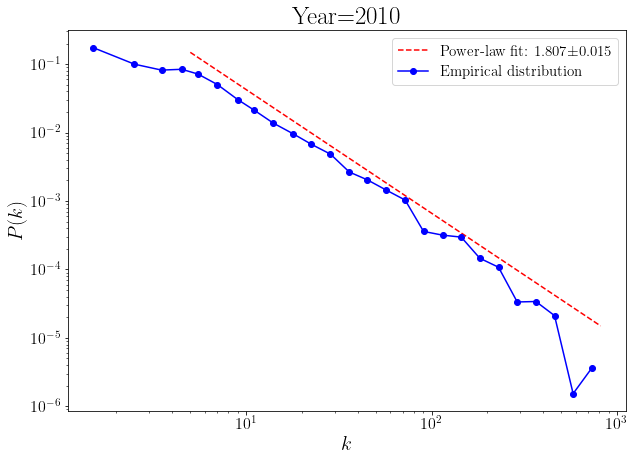

Calculating best minimal value for power law fit


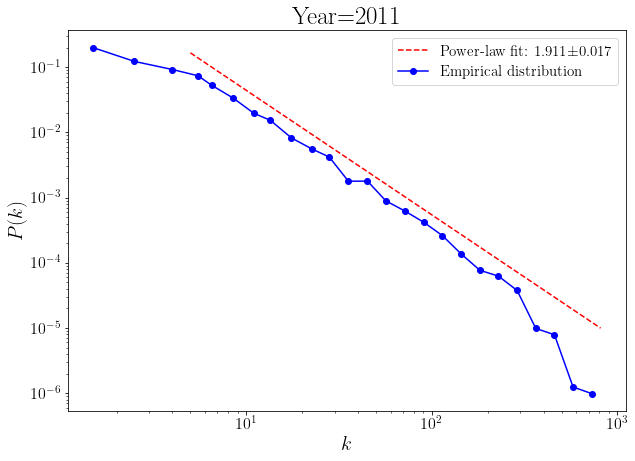

Calculating best minimal value for power law fit


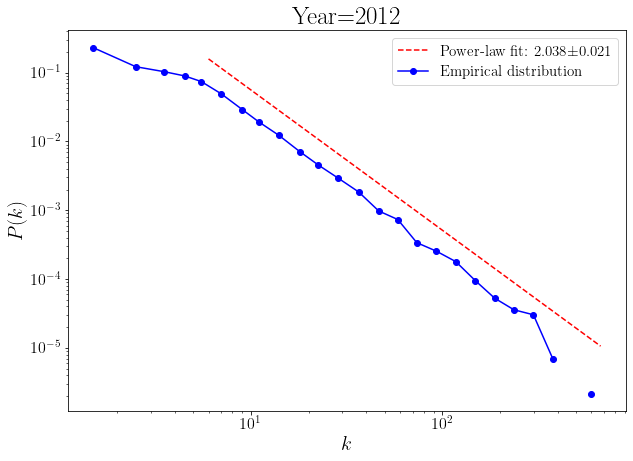

Calculating best minimal value for power law fit


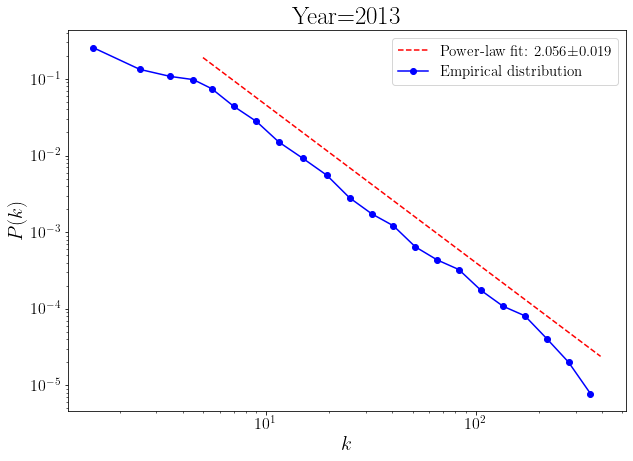

Calculating best minimal value for power law fit


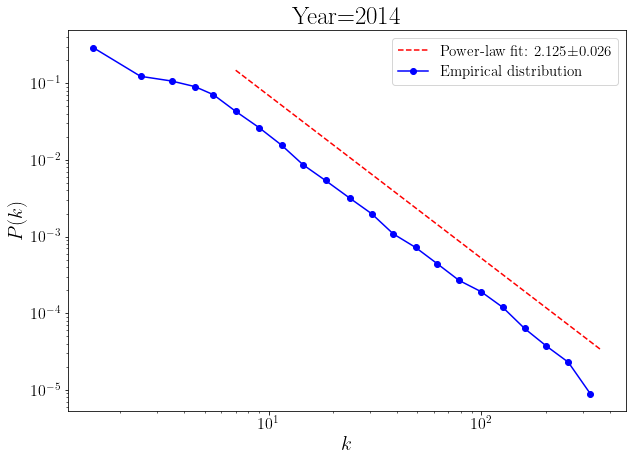

Calculating best minimal value for power law fit


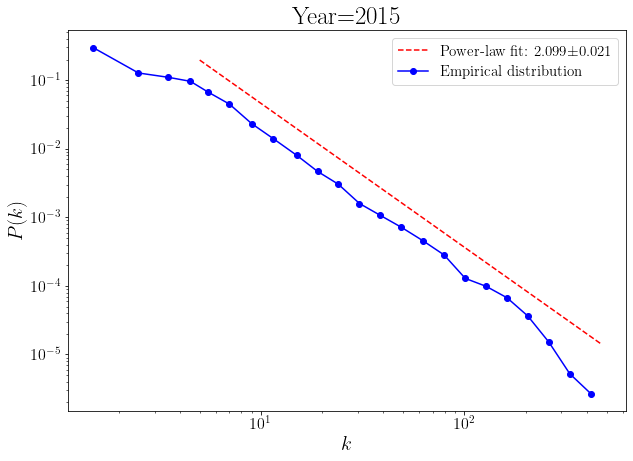

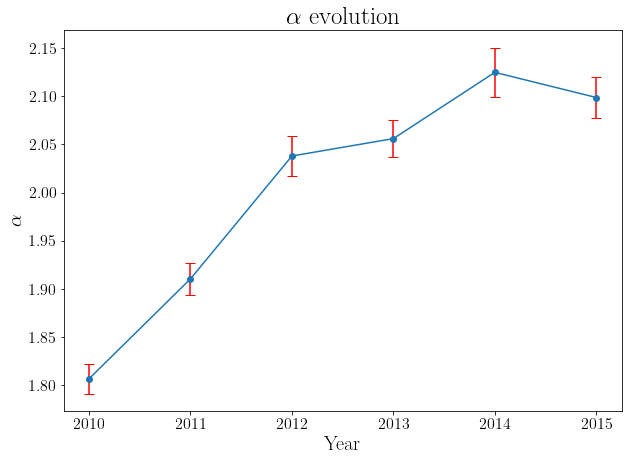

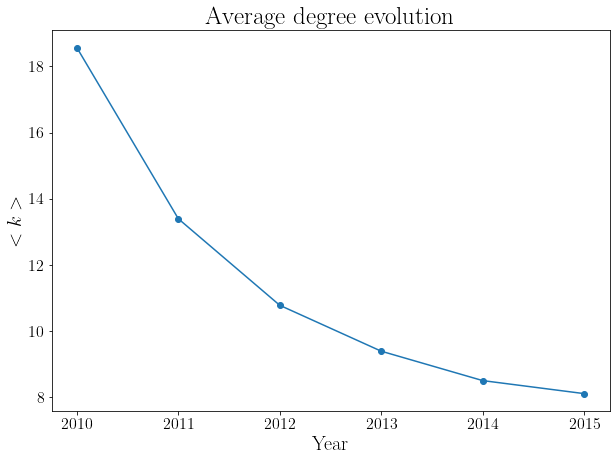

In [19]:
plot_degree_distributions_and_evolutions(years)

Calculating best minimal value for power law fit


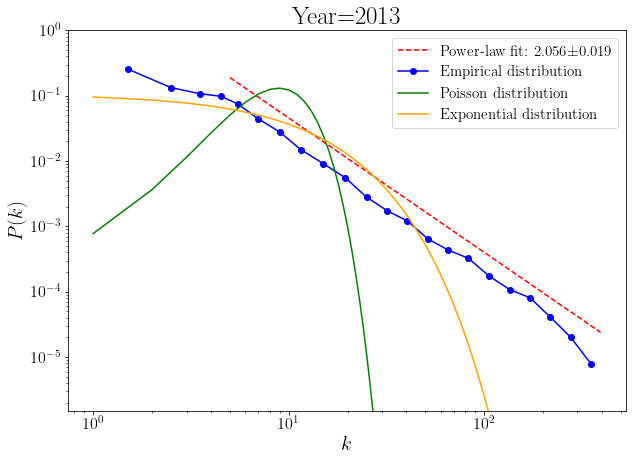

(2.056049613177188, 0.019100142282922904, 9.396201354761589)

In [20]:
plot_degree_distribution_and_fit(load_network_from_year("2013"), "2013", poissonFlag=True, exponentialFlag=True)

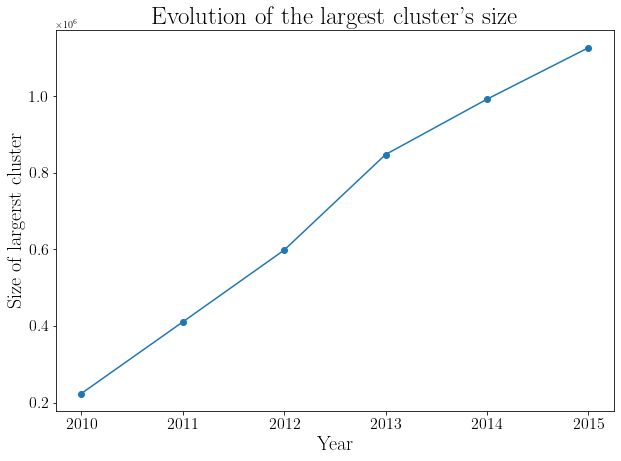

In [24]:
plot_largest_cluster_size_evolution(years)

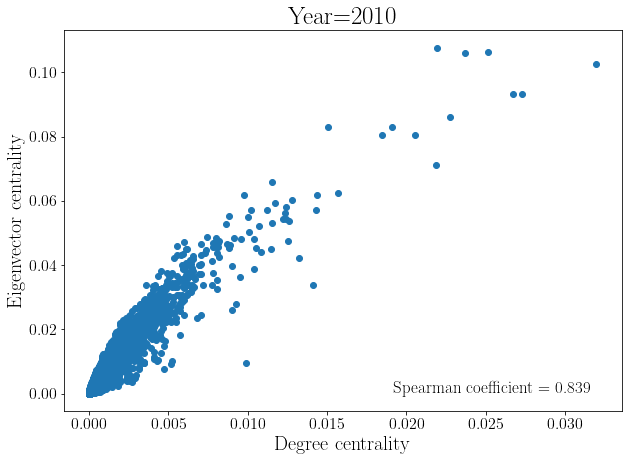

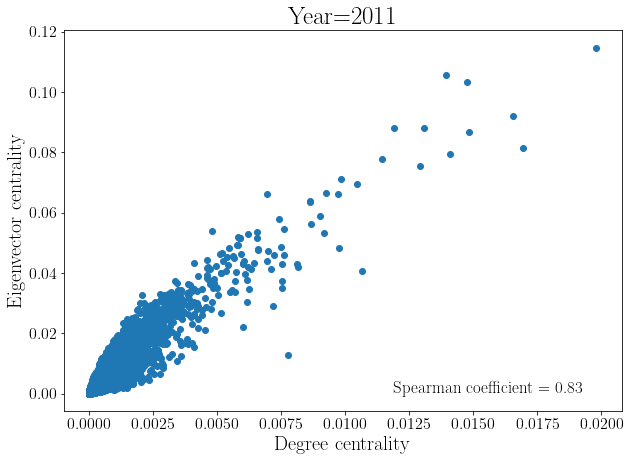

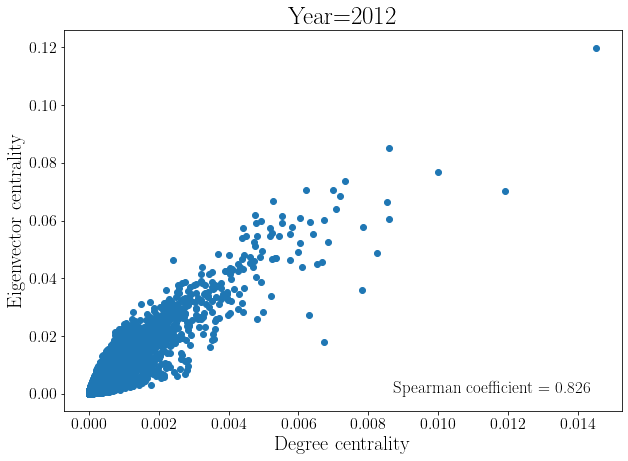

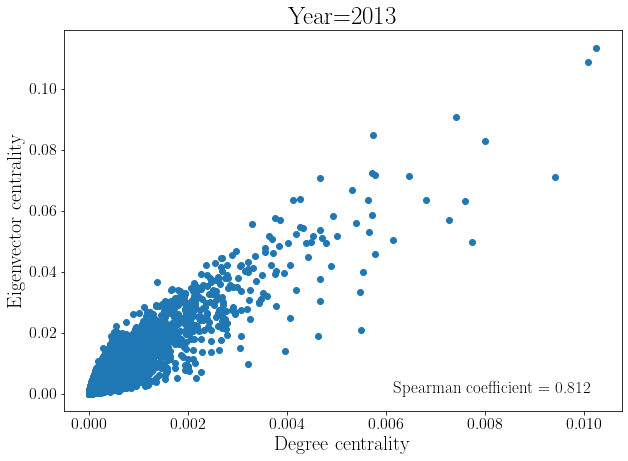

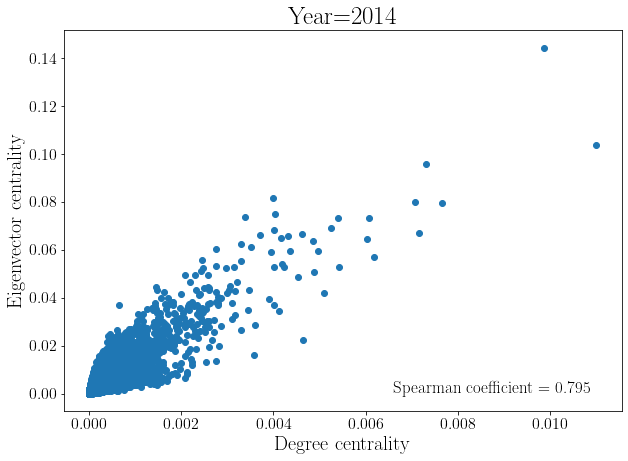

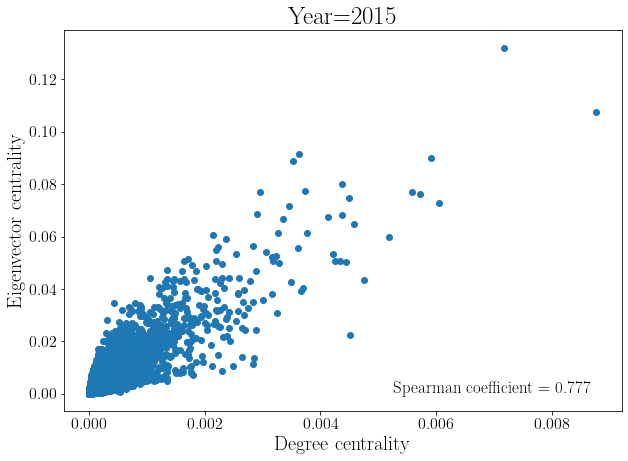

In [25]:
plot_eigenvector_vs_degree_centralities(years)

Calculating best minimal value for power law fit


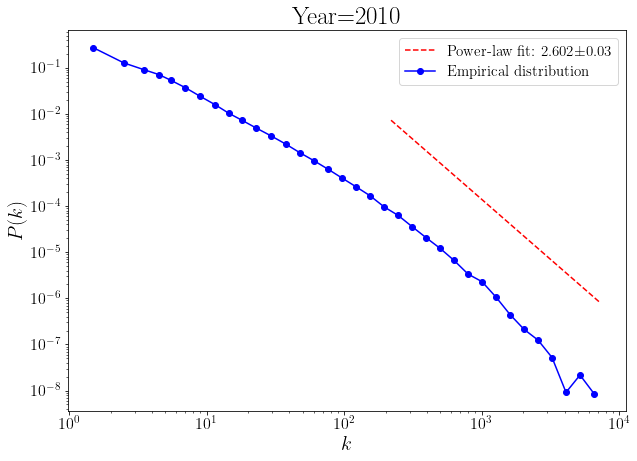

Calculating best minimal value for power law fit


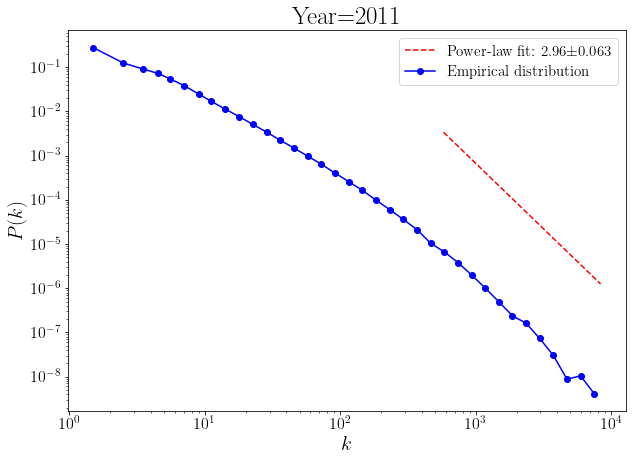

Calculating best minimal value for power law fit


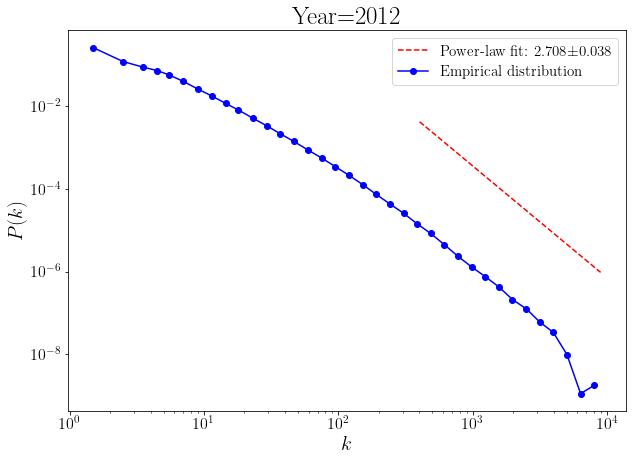

Calculating best minimal value for power law fit


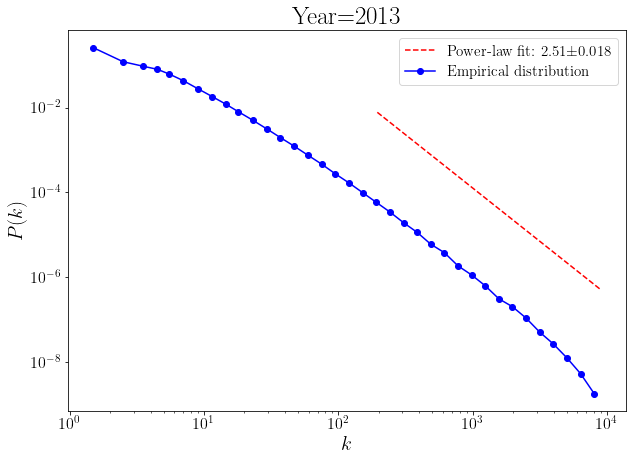

Calculating best minimal value for power law fit


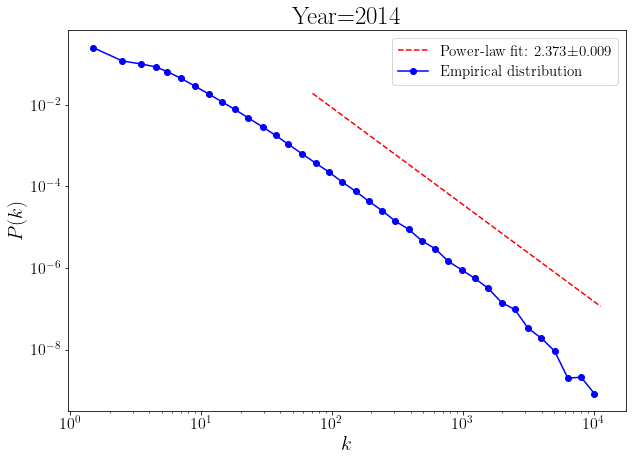

Calculating best minimal value for power law fit


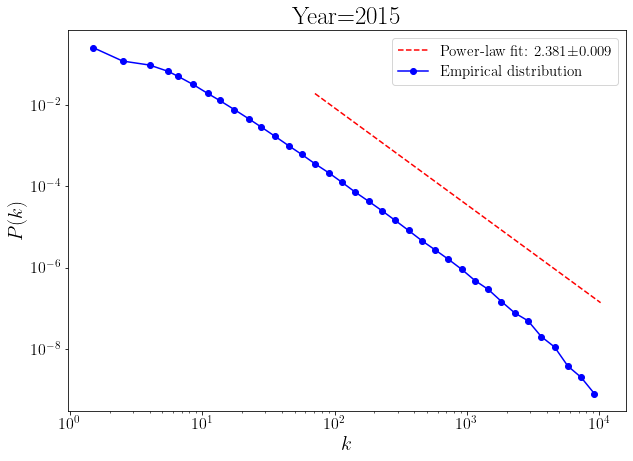

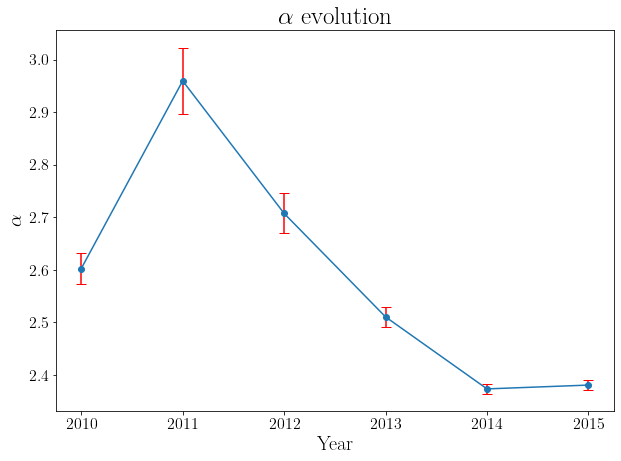

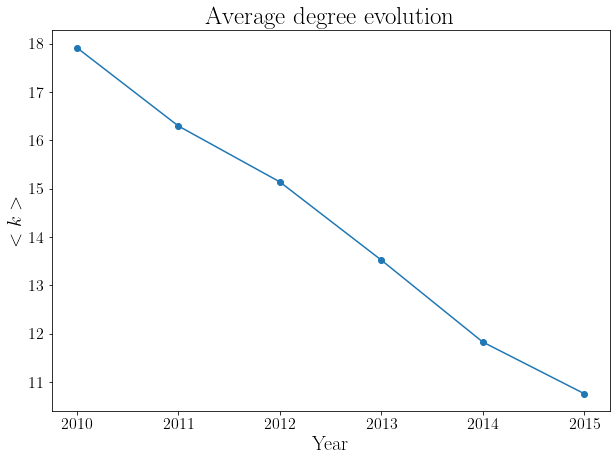

In [16]:
plot_degree_distributions_and_evolutions(years)